In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyomo import environ as pe

# Constrained optimization using pyomo

In [2]:
# Create new model
tmp_model = pe.ConcreteModel()

In [3]:
# Index values
n_channels = 15
channels = [f'C{str(i).rjust(2, "0")}' for i in range(1, n_channels + 1)]

viewers = (
    "Adam",
    "Bob",
    "Cynthia",
    "Dylan",
    "Esther",
    "Frank",
    "Ginny",
    "Hannah",
    "Icabod",
    "Jen"
)

In [4]:
# Define our indices (things our parameters and variables can be defined over)
# -> Here, channels and viewers

tmp_model.channels = pe.Set(initialize=channels)
tmp_model.viewers = pe.Set(initialize=viewers)

In [5]:
# Parameter simulators
# -> Channels: Random cost from 1 to 10
def get_channel_costs(seed=None):
    if seed:
        np.random.seed(seed)
    return dict(
        (channel, np.random.randint(1, 10))
        for channel in channels
    )

# -> Viewership of each channel: Random Bernoulli with 50% likelihood
def get_expected_channel_viewership(seed=None):
    if seed:
        np.random.seed(seed)
    return dict(
        ((channel, viewer), np.random.rand() ** 10)
        for channel in channels
        for viewer in viewers
    )

print(get_channel_costs(666))
print(get_expected_channel_viewership(666))

{'C01': 3, 'C02': 7, 'C03': 5, 'C04': 4, 'C05': 2, 'C06': 1, 'C07': 9, 'C08': 8, 'C09': 6, 'C10': 3, 'C11': 6, 'C12': 6, 'C13': 5, 'C14': 9, 'C15': 5}
{('C01', 'Adam'): 0.028424415843497922, ('C01', 'Bob'): 0.1838166142304941, ('C01', 'Cynthia'): 0.02008029279951641, ('C01', 'Dylan'): 0.041731782883261785, ('C01', 'Esther'): 0.6079894265249001, ('C01', 'Frank'): 1.094284740837001e-19, ('C01', 'Ginny'): 0.0001464455339680855, ('C01', 'Hannah'): 7.679565556640886e-14, ('C01', 'Icabod'): 9.928790541071668e-11, ('C01', 'Jen'): 0.0011460509902417948, ('C02', 'Adam'): 1.036744837045312e-07, ('C02', 'Bob'): 0.05207498943718317, ('C02', 'Cynthia'): 7.130865243763138e-08, ('C02', 'Dylan'): 0.028590270048203668, ('C02', 'Esther'): 4.699546490520935e-06, ('C02', 'Frank'): 0.07764241064700701, ('C02', 'Ginny'): 1.2112170191305365e-23, ('C02', 'Hannah'): 3.3520475315633904e-10, ('C02', 'Icabod'): 2.827592342514114e-10, ('C02', 'Jen'): 8.683663407774235e-07, ('C03', 'Adam'): 4.588488073244127e-17, (

In [6]:
# Define our parameters (fixed external factors)
# -> Here, the channel costs and expected viewership

# Generate costs and expected viewership
tmp_channel_costs = get_channel_costs(666)
tmp_expected_channel_viewership = get_expected_channel_viewership(666)

tmp_model.channel_costs = pe.Param(
    tmp_model.channels,
    initialize = tmp_channel_costs,
    within = pe.NonNegativeIntegers
)
tmp_model.viewership_probabilities = pe.Param(
    # On pyomo Set objects, the * operator returns the Cartesian product
    tmp_model.channels * tmp_model.viewers,
    # The dictionary mapping (channel, viewer) pairs to likelihood of viewership
    initialize = tmp_expected_channel_viewership,
    # Happiness probabilities are real numbers between 0 and 1
    within = pe.UnitInterval
)

In [7]:
# Define our free variables (things we can vary)
# -> Here, just our "buy" matrix

tmp_model.buys = pe.Var(
    # Defined over the channel matrix
    tmp_model.channels,
    # Possible values are 0 and 1
    domain = pe.Binary,
)

In [8]:
# Define our objective
# -> Here the total reach, or the sum of likelihood to view * buys across all possible combinations of channel buys

def get_reach(model):
    # Numerator: Number of distinct viewers with >= 1 expected exposure, as measured by sum(probabilities)
    #num = sum([
    #    model.buys[c] * p
    #    for (c, v), p in model.viewership_probabilities.items()
    #])
    viewer_probabilities_exposed = [
        (v, tmp_model.buys[c] * p)
        for (c, v), p in tmp_model.viewership_probabilities.items()
    ]
    num = sum([p for (v, p) in viewer_probabilities_exposed])
    #viewer_exposed = {
    #    v: sum([vpe_p for vpe_c, vpe_p in viewer_probabilities_exposed if vpe_c == v])
    #    for v in tmp_model.viewers
    #}
    #num = sum([1 for v, e in viewer_exposed.items() if pe.value(e) >= 1])
    
    # Denominator: Number of distinct viewers
    den = len(model.viewers)
    
    return num / den

tmp_model.objective = pe.Objective(
    rule = get_reach,
    sense = pe.maximize
)

In [9]:
# Define our constraints
# -> Here, 
#    1) total cost <= 10
#    2) frequency per viewer <= 2

max_cost = 20
def restrict_total_cost(model):
    # Get total cost
    total_cost = sum([
        model.buys[channel] * cost
        for (channel, cost) in model.channel_costs.items()
    ])
    # Make sure that sum is no more than the maximum cost
    return total_cost <= max_cost

tmp_model.restrict_total_cost = pe.Constraint(
    # Ensure that cost is contained
    rule = restrict_total_cost
)

max_freq = 2
def restrict_viewer_frequency(model, viewer):
    # Get total expected exposure for the user
    viewer_exposure = sum([
        model.buys[c] * p
        for (c, v), p in model.viewership_probabilities.items()
        if v == viewer
    ])
    # Make sure is less than the maximum frequency
    return viewer_exposure <= max_freq

tmp_model.restrict_viewer_frequency = pe.Constraint(
    tmp_model.viewers,
    rule = restrict_viewer_frequency
)

In [10]:
# Solve it!

#import sys
#sys.path.append('C:\\glpk-4.65\\w64')

# Swap out "glpk" for "cbc" or "gurobi" if using another solver
solver = pe.SolverFactory("glpk")
# Add the keyword arg tee=True for a detailed trace of the solver's work.
tmp_solution = solver.solve(
    tmp_model,
    #executable = 'C:\\glpk-4.65\\w64\\glpsol'
)

In [11]:
tmp_solution

{'Problem': [{'Name': 'unknown', 'Lower bound': 0.81412778886892, 'Upper bound': 0.81412778886892, 'Number of objectives': 1, 'Number of constraints': 12, 'Number of variables': 16, 'Number of nonzeros': 166, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '7', 'Number of created subproblems': '7'}}, 'Error rc': 0, 'Time': 0.024001598358154297}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
# Inspect channel buys
for channel, buy in tmp_model.buys.get_values().items():
    print(f'{channel}: {"Bought" if buy == 1 else "Not bought"}')

C01: Bought
C02: Not bought
C03: Not bought
C04: Not bought
C05: Not bought
C06: Bought
C07: Not bought
C08: Not bought
C09: Not bought
C10: Bought
C11: Bought
C12: Not bought
C13: Not bought
C14: Not bought
C15: Bought


In [13]:
# Total exposure per channel
channel_probabilities_exposed = [
    (c, tmp_model.buys.get_values()[c] * p)
    for (c, v), p in tmp_model.viewership_probabilities.items()
]

{
    c: sum([cpe_p for cpe_c, cpe_p in channel_probabilities_exposed if cpe_c == c])
    for c in tmp_model.channels
}

{'C01': 0.8833350289052448,
 'C02': 0.0,
 'C03': 0.0,
 'C04': 0.0,
 'C05': 0.0,
 'C06': 0.5690269074262767,
 'C07': 0.0,
 'C08': 0.0,
 'C09': 0.0,
 'C10': 2.535815825962361,
 'C11': 2.4694577996295544,
 'C12': 0.0,
 'C13': 0.0,
 'C14': 0.0,
 'C15': 1.6836423267657596}

In [14]:
# Total exposure per viewer
viewer_probabilities_exposed = [
    (v, tmp_model.buys.get_values()[c] * p)
    for (c, v), p in tmp_model.viewership_probabilities.items()
]

{
    v: sum([vpe_p for vpe_c, vpe_p in viewer_probabilities_exposed if vpe_c == v])
    for v in tmp_model.viewers
}

{'Adam': 1.650700664450383,
 'Bob': 0.5775688696378342,
 'Cynthia': 0.6108399751289463,
 'Dylan': 0.5026916692026999,
 'Esther': 1.974173486469494,
 'Frank': 0.23431065416094032,
 'Ginny': 0.12938089794900778,
 'Hannah': 1.6413807797133961,
 'Icabod': 0.07988495607013071,
 'Jen': 0.7403459359063637}

<AxesSubplot:xlabel='Viewer', ylabel='Channel'>

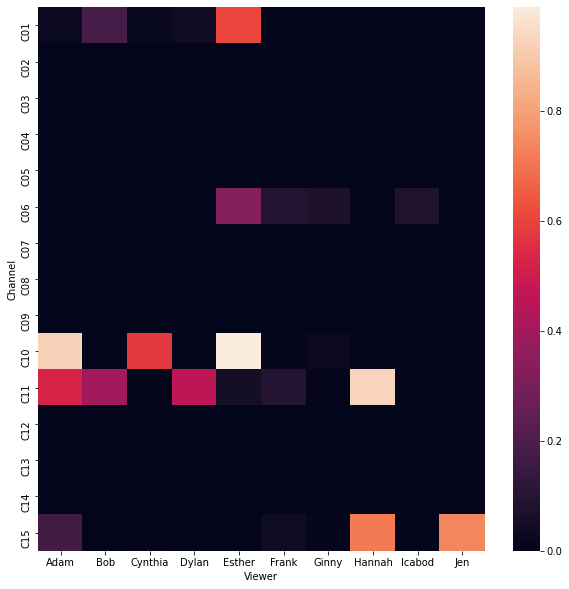

In [15]:
# Create a heatmap of channel exposures
df = pd.DataFrame(
    data=[
        (c, v, tmp_model.buys.get_values()[c] * p)
        for (c, v), p in tmp_model.viewership_probabilities.items()
    ],
    columns = ['Channel', 'Viewer', 'Exposure']
)

plt.figure(figsize=(10, 10))
sns.heatmap(df.pivot('Channel', 'Viewer', 'Exposure'))